# 03 - Interactive Viz

In [1]:
import os
import pandas as pd
import json
import re

import folium
import branca
import matplotlib.pyplot as plt

import geocoder 

%matplotlib inline

DATA_DIR = 'data'
TOPOJSON_DIR = 'topojson'

## Question 1

Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

### Answer

#### Finding out which category to use
After going through the [eurostat](http://ec.europa.eu/eurostat/data/database) database, we found out that there are several datasets with unemployment data. The most reliable of them are the ones under the **"LFS main indicators"** category. We quote the [lfsi metadata page](http://ec.europa.eu/eurostat/cache/metadata/en/lfsi_esms.htm):
> As a result of the application of adjustments, corrections and reconciliation of EU Labour Force Survey (EU-LFS), 'LFS main indicators' is the most complete and reliable collection of employment and unemployment data available in the sub-domain ' Employment and unemployment'.

The problem is that, while the LFS main indicators are supposed, according to the metadata page above, to also be calculated for EFTA countries (i.e. Iceland, Norway and Switzerland), the various unemployment databases (annual, quarterly, monthly) of that category *do not contain Switzerland*, thus disabling us from comparing Switzerland's unemployment to the rest of Europe's.

The weird fact is that the lfsi indicators contain the United States and Japan, presumably for reasons of comparison.

We kept looking into the eurostat database and we found, still under the LFS main indicators category, a category labeled **"LFS series - detailed quarterly survey results (from 1998 onwards) (lfsq)"**. According to the [LFS series metadata page](http://ec.europa.eu/eurostat/cache/metadata/en/lfsq_esms.htm):
> * Unemployed persons are persons aged 15-74 who were without work during the reference week, were currently available for work and were either actively seeking work in the past four weeks or had already found a job to start within the next three months.
> * The economically active population (labour force) comprises employed and unemployed persons.
> * The EU-LFS **covers all industries and occupations**.
> * **Reference area:** European Union, Euro area, the 28 EU-Member States, three EFTA countries (Iceland, which at the same time is a candidate country, Norway and Switzerland), and two acceding and candidate countries, i.e. the former Yugoslav Republic of Macedonia and Turkey.
> * **The overall accuracy is considered as high.** The LFS covers persons living in private households to ensure a comparable coverage for all countries. The sampling designs in the LFS are chosen on a country by country basis. Most of the National Statistical Institutes employ multi-staged stratified random sample design, especially those that do not have central population registers available.

The good thing about the above category is that the data in it indeed contain all the above mentioned countries. After comparing the unemployment rates from the LFS series with the ones from the lfsi indicators, we found out that the numbers were almost the same.

Therefore, in favour of data consistency and to ensure comparability, we chose to analyse the data of the second category, i.e. the LFS series category.

#### Time category selection
The LFS series contain several sheets of data for total unemployment, in which we are interested. The two main sub-categories are *annual* and *quarterly* data. We chose to go with quarterly data, as:
1. we are well through 2017 and the latest annual data we could get are from 2016.
2. with the economy changing fast, they are a more descriptive indicator for the situations of the last few months in each country.

Being in the eurostat [database page](http://ec.europa.eu/eurostat/data/database), the full path to the data we used is:

    > Data nagivation tree
      > Database by themes
        > Population and social conditions
          > Labour market (labour)
            > LFS series - detailed quarterly survey results (from 1998 onwards) (lfsq)
              > Total unemployment - LFS series (lfsq_unemp)
                > Unemployment rates by sex, age and citizenship (%) (lfsq_urgan)

We took the cumulative data regarding all categories (sex, age, citizenship).

The next snippet parses the XLS file downloaded, makes some corrections on the country names and shows the resulting `DataFrame` with the unemployment data. Of course, we are obviously interested in the last column, containing the unemployment rates from Q2 of 2017.

In [2]:
# load the unemployment data into a DataFrame
eurostat_unemp_all = pd.read_excel(os.path.join(DATA_DIR, 'lfsq_urgan.xls'),
                                   sheet_name='Data', skiprows=11, skip_footer=3, index_col=0)

# drop rows which refer to the European Union as a whole
# we only care about individual countries
eurostat_unemp = eurostat_unemp_all.drop([x for x in eurostat_unemp_all.index if x.startswith('Euro')])

# rename Germany and FYROM rows to match the topojson names
eurostat_unemp.rename({
    'Germany (until 1990 former territory of the FRG)': 'Germany',
    'Former Yugoslav Republic of Macedonia, the': 'The former Yugoslav Republic of Macedonia',
}, inplace=True)

# rename index to Country
eurostat_unemp.index.name = 'Country'
# reset index, i.e. convert Country to column
# to use it in cloropleth map
eurostat_unemp.reset_index(level=0, inplace=True)
eurostat_unemp

,Country,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2
0,Belgium,8.8,8.4,8.2,8.7,8.3,7.9,7.9,7.2,7.7,7.0
1,Bulgaria,10.6,9.9,8.3,7.9,8.6,8.1,7.0,6.7,6.9,6.3
2,Czech Republic,6.0,4.9,4.8,4.5,4.4,3.9,4.0,3.6,3.5,3.0
3,Denmark,6.6,6.0,6.2,5.8,6.3,6.0,6.3,6.1,6.5,5.5
4,Germany,5.0,4.7,4.4,4.5,4.5,4.2,4.0,3.8,4.1,3.8
5,Estonia,6.6,6.5,5.2,6.4,6.5,6.5,7.5,6.6,5.6,7.0
6,Ireland,10.0,9.8,9.3,8.7,8.4,8.6,8.0,6.7,6.7,6.4
7,Greece,26.7,24.6,24.1,24.4,24.9,23.1,22.6,23.6,23.4,21.2
8,Spain,23.8,22.4,21.2,20.9,21.0,20.0,18.9,18.6,18.8,17.2
9,France,10.8,10.1,10.0,10.6,10.7,9.6,9.6,10.3,10.0,9.1


The next step is to load Europe's topojson overlays.

In [3]:
# load Europe topojson overlays
eu_geo_path = os.path.join(TOPOJSON_DIR, 'europe.topojson.json')
eu_json_data = json.load(open(eu_geo_path))

After loading Europe's topojson overlays, we need to create the choropleth map based on the unemployment data we have collected.

However, there is one issue: the unemployment data correspond to the current EU countries, the three EFTA countries, as well as some candidate countries, like Turkey. All other European countries do not appear on the unemployment data. Therefore, we need a way to tell the map reader that the data for those countries is not available.

Our solution is the following:
- First, create the choropleth map with the available data. Folium will fill the missing values by colouring the corresponding countries with the first color of the palette (i.e. the one that corresponds to the lowest unemployment).
- Then, for the countries for which we do not have unemployment data, add another layer on top of them with a "neutral" colour, e.g. milky white and opacity 1.0, so that they "mask" the previous colour.

In [4]:
# create a new map of Europe
eu_map = folium.Map([55,20], tiles='cartodbpositron', zoom_start=3, detect_retina=True)

# add choropleth layers based on unemployment data
eu_map.choropleth(geo_data=eu_json_data, data=eurostat_unemp,
                  topojson='objects.europe',
                  columns=['Country', '2017Q2'],
                  key_on='feature.properties.NAME',
                  fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.2,
                  legend_name='Unemployment rate over active population, in 2017-Q2 (Apr-June) - (%)')

def fill_unknown(feature):
    """
    Returns a "decoration" dictionary for the layer that corresponds to feature.
    Its goal is to "mask" the countries for which we do not have unemployment data.
    
    Feature is a dict for each country in Europe's topojson file.
    If we have unemployment data for the country, we set the opacity to 1.0,
    otherwise we set it to zero, i.e. the "mask" layer does not appear at all.
    """
    country = feature['properties']['NAME']
    fill_opacity = 0.0 if country in eurostat_unemp['Country'].values else 0.7
    return {
        'fillColor': '#f0f8ff',
        'fillOpacity': fill_opacity,
        'lineOpacity': 0.2,
        'dashArray': '5',
    }

# add layers for N/A countries
folium.TopoJson(eu_json_data, object_path='objects.europe',
                style_function=fill_unknown).add_to(eu_map)

eu_map.save('Maps/EU_map.html')

# et voilà!
eu_map

The colour palette chosen for the map above is the Yellow-Orange-Red one, with Red representing the higher rates of unemployment. This palette also works nicely with people who suffer from colour blindness.

#### Comparing Switzerland's unemployment to that of the rest of the EU

In order to see how Switzerland's unemployment stacks up against that of the rest of Europe, we will make use of some charts.

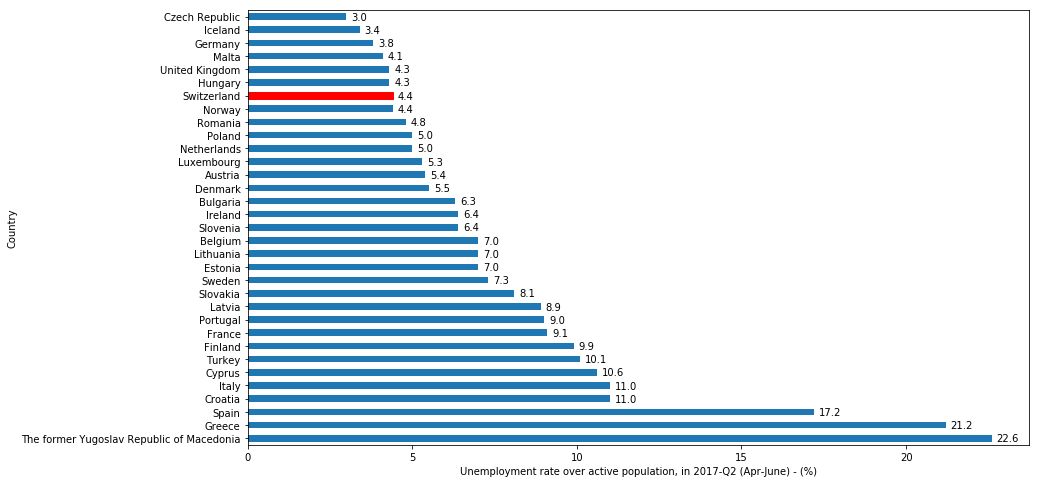

In [5]:
# set the Country as index for the charts
eurostat_unemp.set_index('Country', inplace=True)

# create horizontal (barh) plot
ax = eurostat_unemp['2017Q2'].sort_values(ascending=False) \
                             .plot(kind='barh', figsize=[14,8])

# set label for x-axis
ax.set_xlabel('Unemployment rate over active population, in 2017-Q2 (Apr-June) - (%)')

# add unemployment rates on the plot
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(5, 0), textcoords='offset points')

# color Switzerland entry with red, in order to distinguish it
ax.patches[-7].set_color('red')

As we can see from the bar chart above, Switzerland stacks up nicely against the rest of the European countries, with an unemployment rate of 4,4% for Q2 of 2017, which puts it in the 7th place on the list.

What is more interesting is to see how it stacks up against the average unemployment in the EU area. For this, we will use the data from eurostat, which refer to the various "iterations" of the EU.

,Average Unemployment Rate (%)
Region,
European Union (28 countries),8.80
Euro area (19 countries),10.25
Switzerland,4.89


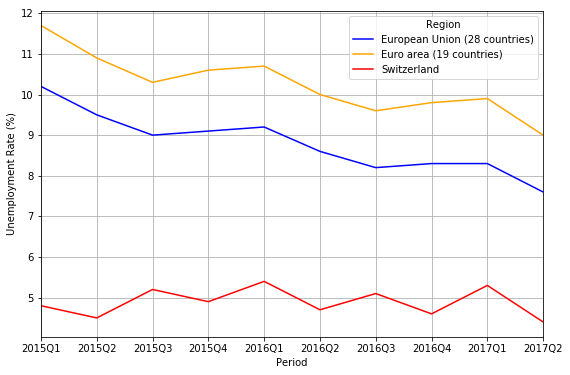

In [6]:
# only keep:
# - European Union (28 countries), from 1 July 2013
#   see: http://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:EU_enlargements
# - Euro area (19 countries), from 1 January 2015
#   see: http://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Euro_area_enlargements
# - Switzerland
eurostat_unemp_eu = eurostat_unemp_all.drop(
    [x for x in eurostat_unemp_all.index
     if not (re.match(r"^euro.*(19|28).*$", x.lower()) or x.startswith('Switzerland'))]
)
eurostat_unemp_eu.index.name = 'Region'
# plot available data
ax = eurostat_unemp_eu.transpose().plot(figsize=[9,6], color=['blue', 'orange', 'red'], grid=True)
# set labels for axis
ax.set_ylabel('Unemployment Rate (%)')
ax.set_xlabel('Period')

# calculate average unemployment rates over the available timeframe
mean_unemp = [
    round(eurostat_unemp_eu.transpose()[x].mean(), 2)
    for x in eurostat_unemp_eu.index
]
# also present a DataFrame
pd.DataFrame(data=mean_unemp, index=eurostat_unemp_eu.index, columns=['Average Unemployment Rate (%)'])

The above plot shows a graphical representation of the unemployment rates in the European Union, the Euro area and Switzerland from Q1-2015 to Q2-2017. There is also a `DataFrame` showing the average unemployment over the available timespan.

What we observe is that **Switzerland has a rather stable rate of unemployment**, which reflects its stable economy over the years, whereas in the EU and the Euro area the rate is twice as much, especially if someone considers Q1-2015.

However, **these results should be taken with a grain of salt**. This is because on one hand, as we can see from the first graph, **the variance** of the unemployment rates among EU and/or EA countries **is quite large** and on the other hand **there are three outliers** in the EU/EA area with very large rates, namely Spain, Greece and FYROM.

## Question 2

Go to the [amstat](https://www.amstat.ch/) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

### Answer

[amstat](https://www.amstat.ch/) provided to us a dataset that includes:
Canton names, number of Unemployed people, Job Seekers, Employed Seekers and Unemployed Seekers.

In [7]:
amstat_df1 = pd.read_excel('RegisteredOverallFr.xlsx', skiprows=3)

In [8]:
amstat_df1.drop(['Mesures', 'Demandeurs d\'emploi entrés'], axis=1, inplace=True)
amstat_df1.rename(columns={'Unnamed: 0': 'Canton', 'Chômeurs inscrits': 'Unemployed', 'Demandeurs d\'emploi':'Job_Seekers','Demandeurs d\'emploi non chômeurs':'Employed_Seekers','Demandeurs d\'emploi sortis':'Unemployed_Seekers'}, inplace=True)
amstat_df1 = amstat_df1[amstat_df1['Canton'] != 'Total']

In [9]:
amstat_df1.head()

,Canton,Unemployed,Job_Seekers,Employed_Seekers,Unemployed_Seekers
0,Zurich,27225,34156,6931,5438
1,Berne,13658,18385,4727,2596
2,Lucerne,3885,6756,2871,1043
3,Uri,112,257,145,64
4,Schwyz,1455,2229,774,362


### To create a choropleth map, canton names in the amstat_df_uneployment1 Dataframe need to match the canton names in the json provided!

In [10]:
json_data = pd.read_json('topojson/ch-cantons.topojson.json', typ='dataframe')
cantonid = [item['id'] for item in json_data['objects']['cantons']['geometries']]
cantonname =[item['properties']['name'] for item in json_data['objects']['cantons']['geometries']]
swiss_cantons = dict(zip(cantonid,cantonname))
swiss_cantons

{'AG': 'Aargau',
 'AI': 'Appenzell Innerrhoden',
 'AR': 'Appenzell Ausserrhoden',
 'BE': 'Bern/Berne',
 'BL': 'Basel-Landschaft',
 'BS': 'Basel-Stadt',
 'FR': 'Fribourg',
 'GE': 'Genève',
 'GL': 'Glarus',
 'GR': 'Graubünden/Grigioni',
 'JU': 'Jura',
 'LU': 'Luzern',
 'NE': 'Neuchâtel',
 'NW': 'Nidwalden',
 'OW': 'Obwalden',
 'SG': 'St. Gallen',
 'SH': 'Schaffhausen',
 'SO': 'Solothurn',
 'SZ': 'Schwyz',
 'TG': 'Thurgau',
 'TI': 'Ticino',
 'UR': 'Uri',
 'VD': 'Vaud',
 'VS': 'Valais/Wallis',
 'ZG': 'Zug',
 'ZH': 'Zürich'}

In [11]:
amstat_df1.Canton.isin(swiss_cantons.values())

0     False
1     False
2     False
3      True
4      True
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21     True
22    False
23     True
24     True
25     True
Name: Canton, dtype: bool

We observe that only a few canton names match the ones in the json file provided.
So we have to use string similarity metrics and then pass the canton names obtained from the json file to the column Canton of amstat_df1 Dataframe

In [12]:
import itertools
import re
from fuzzywuzzy import fuzz

# calculate similarities between the Canton names of our dataset and the json file 
def similarity_ratio(x, y):
    """
    Given two strings x and y, find their similarity ratio.
    
    The algorithm is outlined below:
        1. Tokenize the two strings.
        2. Find the common tokens.
        3. Remove the common tokens from each of x and y and obtain xcomp and ycomp.
           This will result in differing tokens to have a greater impact on similarity drop.
        4. If either one of two strings remains empty, return the similarity ratio of the original strings (x, y),
           otherwise, return the similarity ratio of (xcomp, ycomp).
    """
    xtokens = set(x.replace('–', '').replace('-', '').split(' '))
    ytokens = set(y.replace('–', '').replace('-', '').split(' '))
    common_tokens = xtokens & ytokens  # set intersection
    # discard common tokens
    ytokens -= common_tokens
    xtokens -= common_tokens
    return fuzz.token_sort_ratio(' '.join(xtokens), ' '.join(ytokens)) if xtokens and ytokens else fuzz.ratio(x, y)

In [13]:
s1 = pd.Series()
L = {((i, x), (j, y), similarity_ratio(x, y))
     for (i, x), (j, y) in itertools.product(enumerate(amstat_df1.Canton),
                                             enumerate(swiss_cantons.values()))}
# keep in L1 only those names that have partial similarity ratio > 80%
L1 = set(filter(lambda x: x[2] > 80, L))
# we have decided to keep the names from the json file
# s1 contains indexes from the dataframe
s1 = s1.append(pd.Series((t[1] for _, t, _ in L1), index=(t[0] for t, _, _ in L1)))
# remove the matched names from L
for elem in L1:
    (_, xx), (_, yy), _ = elem
    L = {((i, x), (j, y), v) for (i, x), (j, y), v in L if {xx, yy}.isdisjoint({x, y})}

In [14]:
#the size of the canton names that matched
print(s1.size)

13


In [15]:
# keep in L1 only those names that have partial similarity ratio > 60%
L1 = set(filter(lambda x: x[2] >= 60, L))
# we have decided to keep the names from the json file
s1 = s1.append(pd.Series((t[1] for _, t, _ in L1), index=(t[0] for t, _, _ in L1)))
# remove the matched names from L
for elem in L1:
    (_, xx), (_, yy), _ = elem
    L = {((i, x), (j, y), v) for (i, x), (j, y), v in L if {xx, yy}.isdisjoint({x, y})}

In [16]:
#the size of the canton names that matched
print(s1.size)

18


So far we have 18 matched out of 26

In [17]:
# keep in L1 only those names that have partial similarity ratio > 45%
L1 = set(filter(lambda x: x[2] >= 45, L))
s1 = s1.append(pd.Series((t[1] for _, t, _ in L1), index=(t[0] for t, _, _ in L1)))
# remove the matched names from L
for elem in L1:
    (_, xx), (_, yy), _ = elem
    L = {((i, x), (j, y), v) for (i, x), (j, y), v in L if {xx, yy}.isdisjoint({x, y})}

In [18]:
#elements left to match!
s1.set_value(11, 'Basel-Stadt')
s1.set_value(12, 'Basel-Landschaft')
s1.set_value(14, 'Appenzell Rhodes-Extérieures')
s1.set_value(15, 'Appenzell Innerrhoden')
s1.set_value(17, 'Graubünden/Grigioni')

5                         Obwalden
21                            Vaud
24                          Genève
9                         Fribourg
4                           Schwyz
8                              Zug
6                        Nidwalden
23                       Neuchâtel
7                           Glarus
3                              Uri
25                            Jura
13                    Schaffhausen
0                           Zürich
2                           Luzern
19                         Thurgau
10                       Solothurn
1                       Bern/Berne
22                   Valais/Wallis
20                          Ticino
18                          Aargau
16                      St. Gallen
11                     Basel-Stadt
12                Basel-Landschaft
14    Appenzell Rhodes-Extérieures
15           Appenzell Innerrhoden
17             Graubünden/Grigioni
dtype: object

In [19]:
print(s1.size)
s1.sort_index(inplace=True)
amstat_df1 = amstat_df1.assign(Canton = s1)

26


Now we use **geocoder** to obtain the location of each Canton and draw Markers on folium Map

In [20]:
def get_location(canton):
    g = geocoder.google(canton)
    return g.latlng

In [21]:
# dictionary: key = canton name; value = canton location
canton_locs = {}
for canton_name in amstat_df1.Canton:
    location = get_location(canton_name)
    if location:
        canton_locs[canton_name] = location

This dataset does not include the numbers of active population of each Canton, so we analyze the data with various ways, to conclude some interesting results.

#### First we define uneployment rates by computing the ratio of Unemployed people who are looking for a job('Unemployed_Seekers') to the number of people who are looking for a job('Job_Seeker')

In [22]:
amstat_df1

,Canton,Unemployed,Job_Seekers,Employed_Seekers,Unemployed_Seekers
0,Zürich,27225,34156,6931,5438
1,Bern/Berne,13658,18385,4727,2596
2,Luzern,3885,6756,2871,1043
3,Uri,112,257,145,64
4,Schwyz,1455,2229,774,362
5,Obwalden,153,319,166,53
6,Nidwalden,248,436,188,66
7,Glarus,416,713,297,95
8,Zug,1543,2615,1072,374
9,Fribourg,4466,7837,3371,1122


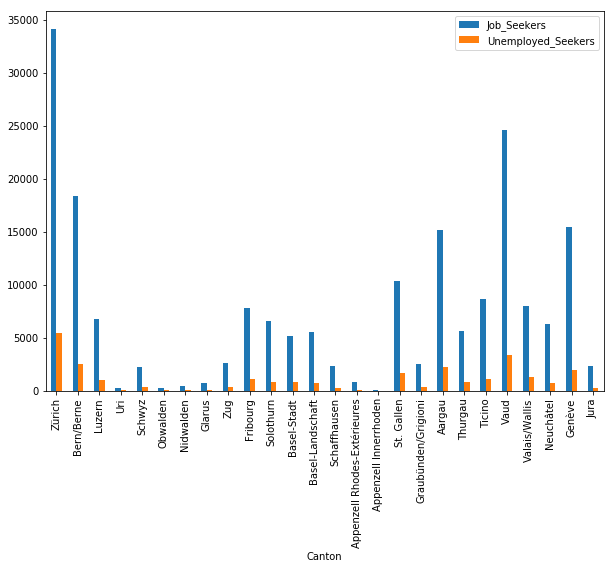

In [23]:
amstat_df1.plot(x='Canton', y = ['Job_Seekers','Unemployed_Seekers'],kind='bar', figsize=[10,7])

In [24]:
amstat_df1['Unemployment_Rate']=0.0
def formula(row):
     return ((row['Unemployed_Seekers'] / row['Job_Seekers']) * 100.0)

In [25]:
amstat_df1['Unemployment_Rate'] = amstat_df1.apply(lambda x: formula(x), axis=1)
amstat_df1.head()

,Canton,Unemployed,Job_Seekers,Employed_Seekers,Unemployed_Seekers,Unemployment_Rate
0,Zürich,27225,34156,6931,5438,15.921068
1,Bern/Berne,13658,18385,4727,2596,14.120207
2,Luzern,3885,6756,2871,1043,15.438129
3,Uri,112,257,145,64,24.902724
4,Schwyz,1455,2229,774,362,16.240467


In [26]:
amstat_df_unemployment1 = amstat_df1[['Canton','Unemployment_Rate']].sort_values('Unemployment_Rate')
amstat_df_unemployment1.head()

,Canton,Unemployment_Rate
23,Neuchâtel,12.031496
13,Schaffhausen,12.457045
24,Genève,12.550816
25,Jura,12.673684
10,Solothurn,13.307182


In [27]:
amstat_df_unemployment1.mean()

Unemployment_Rate    14.917477
dtype: float64

In [28]:
# load Swiss Canton topojson overlays
swiss_geo_path = os.path.join(TOPOJSON_DIR, 'ch-cantons.topojson.json')
swiss_json_data = json.load(open(swiss_geo_path))

After loading Swiss' topojson overlays, we need to create the choropleth map based on the unemployment rate we have computed.

In [29]:
# create a new map of Switzerland
swiss_map = folium.Map([46.762579, 7.927242], zoom_start=6)

# add choropleth layers based on unemployment data
swiss_map.choropleth(geo_data=swiss_json_data, data=amstat_df_unemployment1,
                  topojson='objects.cantons',
                  columns=['Canton', 'Unemployment_Rate'],
                  key_on='feature.properties.name', 
                  fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.2,
                  legend_name='Unemployment rate of Swiss Cantons basend on our criteria')

for key,value in canton_locs.items():
    folium.Marker(value, popup=key).add_to(swiss_map)

swiss_map.save('Maps/swiss-map1.html')

swiss_map

**NOTE: To see the map, please click <a href="Maps/swiss-map1.html"> here</a> **

#### Now we don't count in our analysis people who already have a job and are looking for a new one.
So we first subtract ftom the total number of Job Seekers the number of the people of the  aforementioned category!
Of course, since the total number of Job Seekers is getting decreased we expect that the unemployment rate will be greater than the previous one, but we accept that and we want to investigate the distinct rates of each canton.

In [30]:
amstat_df1['Job_Seekers_not_employed'] = amstat_df1['Job_Seekers'].subtract(amstat_df1['Employed_Seekers'])

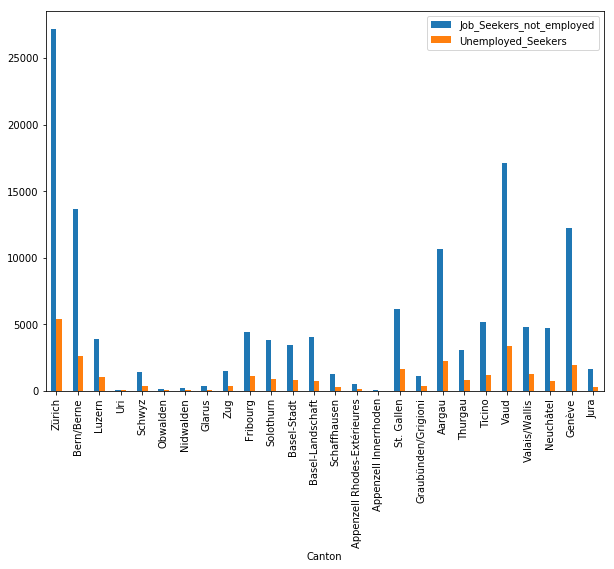

In [31]:
amstat_df1.plot(x='Canton', y = ['Job_Seekers_not_employed','Unemployed_Seekers'],kind='bar', figsize=[10,7])

In [32]:
amstat_df1['Unemployment_Rate2']=0.0
def formula(row):
     return ((row['Unemployed_Seekers'] / row['Job_Seekers_not_employed']) * 100.0)

In [33]:
amstat_df1['Unemployment_Rate2'] = amstat_df1.apply(lambda x: formula(x), axis=1)
amstat_df1.head()

,Canton,Unemployed,Job_Seekers,Employed_Seekers,Unemployed_Seekers,Unemployment_Rate,Job_Seekers_not_employed,Unemployment_Rate2
0,Zürich,27225,34156,6931,5438,15.921068,27225,19.974288
1,Bern/Berne,13658,18385,4727,2596,14.120207,13658,19.007175
2,Luzern,3885,6756,2871,1043,15.438129,3885,26.846847
3,Uri,112,257,145,64,24.902724,112,57.142857
4,Schwyz,1455,2229,774,362,16.240467,1455,24.879725


In [34]:
amstat_df_unemployment2 = amstat_df1[['Canton','Unemployment_Rate2']].sort_values('Unemployment_Rate2')
amstat_df_unemployment2.head()

,Canton,Unemployment_Rate2
24,Genève,15.898316
23,Neuchâtel,16.124947
25,Jura,18.591723
1,Bern/Berne,19.007175
12,Basel-Landschaft,19.402254


In [35]:
amstat_df_unemployment2.mean()

Unemployment_Rate2    24.924877
dtype: float64

After loading Swiss' topojson overlays, we need to create the choropleth map based on the unemployment rate we have computed.

In [36]:
# create a new map of Switzerland
swiss_map = folium.Map([46.762579, 7.927242], zoom_start=6)

# add choropleth layers based on unemployment data
swiss_map.choropleth(geo_data=swiss_json_data, data=amstat_df_unemployment2,
                  topojson='objects.cantons',
                  columns=['Canton', 'Unemployment_Rate2'],
                  key_on='feature.properties.name',
                  fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.2,
                  legend_name='Unemployment rate(2) of Swiss Cantons basend on our criteria')

for key,value in canton_locs.items():
    folium.Marker(value, popup=key).add_to(swiss_map)

swiss_map.save('Maps/swiss-map2.html')

swiss_map

**NOTE: To see the map, please click <a href="Maps/swiss-map2.html"> here</a> **

We conclude that in both cases, there are only a few differences.
- Cantons such as Uri, Obwalden, Valais appear in both cases with high unemployment rates.
- On the other hand, Geneva and Bern in both cases have low unemployment rates.
- Exception: The canton of Graubünden in the first case is among the cantons with low unemployment rates, but in the second case Graubünden does not seem to have low unemployment rate.

## Question 3

Use the [amstat](https://www.amstat.ch/) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (_hint_ The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

### Answer

#### Unemployment distincting Swiss/Foreign population

[amstat](https://www.amstat.ch/) provides a dataset containing the unemployment rates by nationality (Swiss, foreign). We extracted and saved this dataset (`data/taux_de_chomage_nationalite.xlsx`).

The first step is to open and "parse" it. The following code snippet does the following:
* loads the Excel file with unemployment data by nationality.
* renames the columns of the resulting `DataFrame` to English.
* drops unnecessary cells (rows/columns) and converts the rates to numerical data.
* adds Canton IDs to the `DataFrame`, to match with the topojson file.

In [37]:
# load Excel file with unemployment data
unemp_suisse_nat = pd.read_excel(os.path.join(DATA_DIR, 'taux_de_chomage_nationalite.xlsx'),
                                 sheet_name=0, skiprows=3, skip_footer=1, usecols=[0,1,3,5],
                                 names=['Canton', 'Nationality', 'Rate', 'Number'])

# convert rate and number to numeric
unemp_suisse_nat['Rate'] = pd.to_numeric(unemp_suisse_nat['Rate'])
unemp_suisse_nat['Number'] = pd.to_numeric(unemp_suisse_nat['Number'])

# canton names to IDs dict
canton_name_to_id = {
    'Zurich': 'ZH',
    'Berne': 'BE',
    'Lucerne': 'LU',
    'Uri': 'UR',
    'Schwyz': 'SZ',
    'Obwald': 'OW',
    'Nidwald': 'NW',
    'Glaris': 'GL',
    'Zoug': 'ZG',
    'Fribourg': 'FR',
    'Soleure': 'SO',
    'Bâle-Ville': 'BS',
    'Bâle-Campagne': 'BL',
    'Schaffhouse': 'SH',
    'Appenzell Rhodes-Extérieures': 'AR',
    'Appenzell Rhodes-Intérieures': 'AI',
    'St-Gall': 'SG',
    'Grisons': 'GR',
    'Argovie': 'AG',
    'Thurgovie': 'TG',
    'Tessin': 'TI',
    'Vaud': 'VD',
    'Valais': 'VS',
    'Neuchâtel': 'NE',
    'Genève': 'GE',
    'Jura': 'JU',
}

# assign canton IDs    
unemp_suisse_nat['ID'] = unemp_suisse_nat.apply(lambda row: canton_name_to_id[row['Canton']], axis=1)
unemp_suisse_nat.head(8)

,Canton,Nationality,Rate,Number,ID
0,Zurich,Etrangers,5.3,12111,ZH
1,Zurich,Suisses,2.5,15114,ZH
2,Berne,Etrangers,5.5,4900,BE
3,Berne,Suisses,1.8,8758,BE
4,Lucerne,Etrangers,3.9,1593,LU
5,Lucerne,Suisses,1.3,2292,LU
6,Uri,Etrangers,2.1,53,UR
7,Uri,Suisses,0.4,59,UR


The next step is to load the topojson file with the Swiss cantons.

In [38]:
# load Switzerland topojson overlays
suisse_geo_path = os.path.join(TOPOJSON_DIR, 'ch-cantons.topojson.json')
suisse_json_data = json.load(open(suisse_geo_path))

We are now ready to create the Switzerland map and plot the unemployment data on it.

In order to plot unemployment data for **both Swiss and foreign population in a single map**, we create **two layers**, each with its own colormap. The one displaying unemployment for the Swiss population is coloured with a Yellow-Orange-Red palette, while the one displaying unemployment for the foreign population is coloured with a Purple-Blue-Green palette.

The Swiss layer is always activated. The foreign layer can be toggled via the layer control at the top right of the map.

A nice property of the aforementioned colormaps is that they do not interfere with one another when both layers are activated. Actually, when activated, the foreign layer sits on top of the Swiss one and masks it.

In [39]:
# create a new map of Switzerland
suisse_map = folium.Map([46.9,8.55], tiles='cartodbpositron', zoom_start=8, detect_retina=True)

# split unemployment DataFrame into "suisses" and "etrangers"
unemp_suisse_suisses = unemp_suisse_nat[unemp_suisse_nat.Nationality == 'Suisses']
unemp_suisse_etrangers = unemp_suisse_nat[unemp_suisse_nat.Nationality == 'Etrangers']

# create colormaps for the choropleth map layers
# see: https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb
colormap_suisses = branca.colormap.linear.YlOrRd.scale(unemp_suisse_suisses.Rate.min(),
                                                       unemp_suisse_suisses.Rate.max())
colormap_suisses.caption = 'Unemployment rate for Swiss population - September 2017 (%)'

colormap_etrangers = branca.colormap.linear.PuBuGn.scale(unemp_suisse_etrangers.Rate.min(),
                                                         unemp_suisse_etrangers.Rate.max())
colormap_etrangers.caption = 'Unemployment rate for foreign population - September 2017 (%)'

# convert DataFrames to panda Series, so that we can map the data to the choropleth map
unemp_suisse_suisses_dict = unemp_suisse_suisses.set_index('ID')['Rate']
unemp_suisse_etrangers_dict = unemp_suisse_etrangers.set_index('ID')['Rate']

# add choropleth layer for unemployment of Swiss population
suisse_unemp_layer = folium.TopoJson(suisse_json_data, object_path='objects.cantons',
                                     control=False,
                                     style_function=lambda feature: {
                                         'fillColor': colormap_suisses(unemp_suisse_suisses_dict[feature['id']]),
                                         'color': 'black',
                                         'weight': 0.2,
                                         'fillOpacity': 0.45,
                                         'lineOpacity': 0.2,
                                     })

# add choropleth layer for unemployment of foreign population
etrangers_unemp_layer = folium.TopoJson(suisse_json_data, object_path='objects.cantons',
                                        name='Toggle unemployment (Swiss/Foreigners)',
                                        style_function=lambda feature: {
                                            'fillColor': colormap_etrangers(unemp_suisse_etrangers_dict[feature['id']]),
                                            'color': 'black',
                                            'weight': 0.2,
                                            'fillOpacity': 0.7,
                                            'lineOpacity': 0.2,
                                        })

# add layers to map
suisse_map.add_child(suisse_unemp_layer)
suisse_map.add_child(colormap_suisses)
suisse_map.add_child(etrangers_unemp_layer)
suisse_map.add_child(colormap_etrangers)
# add layer control
suisse_map.add_child(folium.map.LayerControl(collapsed=False))
# save map
suisse_map.save('Maps/swiss-map3.html')
# show map
suisse_map

**NOTE: To see the map, please click <a href="Maps/swiss-map3.html"> here</a> **

#### Observations

We observe that, in general, unemployment rates for foreign people are higher than the respective rates for Swiss people, even though the absolute number of unemployed Swiss people is larger than that of foreigners.

This is normal, as there are normally more Swiss people living in Switzerland and thus in Switzerland's active population.

Furthermore, we observe that unemployment rates are higher in the big cities, as in Zurich, Geneva, Lausanne, Lucern and Basel. This is also normal, because in big cities there are more people competing for the available jobs.

Last, there seems to be a tendency for unemployment levels to be higher in the French side of Switzerland, although not by much. More on that, in Question 4.

#### Adding the age groups
We will now also add the age groups into the game.

To do that, we need two other datasets:
* one containing the unemployment rates by age groups (`data/taux_de_chomage-classes_d_age.xlsx`).
* one containing the unemployed people by nationality and age (`data/chomeurs_nationalite_et_age.xlsx`).

The following code snippet loads the above mentioned Excel files into `DataFrame`s.

In [40]:
# rename unemployment rates by nationality for code clearance
unemp_rates_nat = unemp_suisse_nat

# load unemployment rates by age group
unemp_rates_age = pd.read_excel(
    os.path.join(DATA_DIR, 'taux_de_chomage-classes_d_age.xlsx'),
    sheet_name=0, skiprows=3, skip_footer=1, usecols=[0,2,4,5],
    names=['Canton', 'Category', 'Rate', 'Number'])
unemp_rates_age['ID'] = unemp_rates_age.apply(lambda row: canton_name_to_id[row['Canton']], axis=1)

# load unemployment counters by nationality and age groups
unemp_count_nat_age = pd.read_excel(
    os.path.join(DATA_DIR, 'chomeurs_nationalite_et_age.xlsx'),
    sheet_name=0, skiprows=3, skip_footer=1, usecols=[0,1,3,4,7],
    names=['Canton', 'Nationality', 'Category', 'ind', 'Number'])
unemp_count_nat_age['ID'] = unemp_count_nat_age.apply(lambda row: canton_name_to_id[row['Canton']], axis=1)

# post-processing...
# only keep columns showing total values
unemp_count_nat_age = unemp_count_nat_age[unemp_count_nat_age.ind == 'Total']
# get rid of "ind" (stands for indicator) column, used just above
unemp_count_nat_age.drop('ind', axis=1, inplace=True)

##### Inferring the active population
One challenge in the context of this analysis, is that **we do not have the individual active populations from each category** (Swiss/Foreigners and for each age group). Furthermore, for the doubly categorised data (by nationality and age), the dataset measures unemployment in number of people (we have no rate available).

However, this is easy to overcome. We take into account that the datasets containing the unemployment rate, also include the number of unemployed people. Since, according to amstat, this rate measures the number of people **of the active population** that are unemployed, we can easily infer the active population, as described below.

Given the datasets that we have:
* unemployment rates by nationality (unemployment rate and number of unemployed people)
* unemployment rates by age (unemployment rate and number of unemployed people)
* unemployed people by nationality and age (number of unemployed people)

we can infer the population for each category, as follows:

$$\text{"active" population} = \left\lfloor\frac{\text{# unemployed people}}{\text{rate of unemployment}} \cdot 100 \right\rfloor$$

The next code snippet does that (for each nationality and age category).

In [41]:
# infer active population for unemployment rates by nationality
unemp_rates_nat['Population'] = unemp_rates_nat.apply(lambda row: int(row['Number'] / row['Rate'] * 100), axis=1)
# infer active population for unemployment rates by age group
unemp_rates_age['Population'] = unemp_rates_age.apply(lambda row: int(row['Number'] / row['Rate'] * 100), axis=1)

**We now have, for each Canton, all active populations:**
* number of Swiss active people
* number of foreign active people
* number of active people between 15 and 24 years old
* number of active people between 25 and 49 years old
* number of active people who are 50 years old and above

**However**, what **we do not have** is the active population **per nationality, per age group**.

Thus, in order to be able to show the intended behaviour, we need to make some assumptions regarding the distribution of the population.

Let us observe the distribution of Switzerland's active people to the three age-groups, per canton.

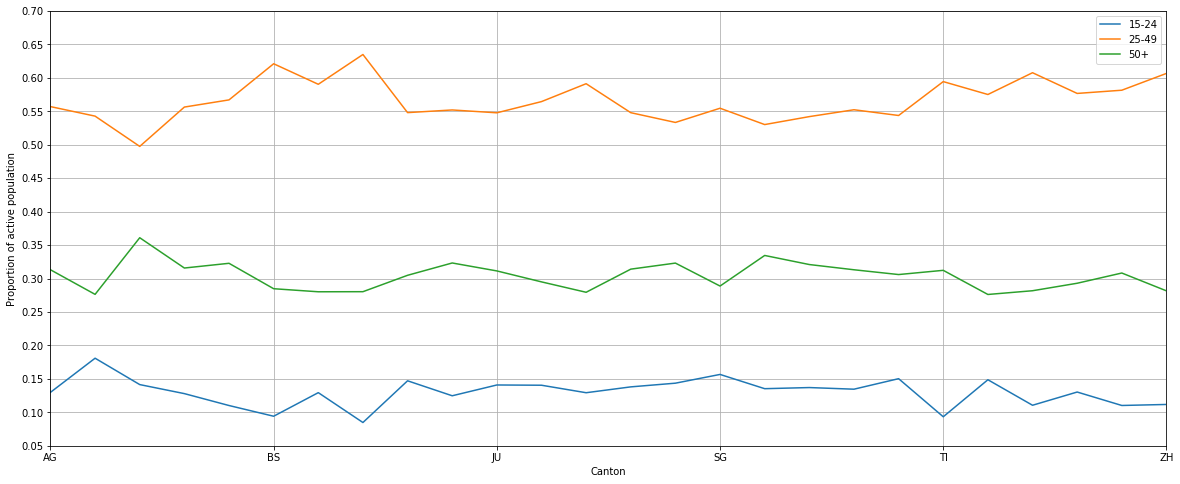

In [42]:
def proportion(group, which):
    """
    which can be:
    - age_15_24
    - age_25_49
    - age_50_plus
    """
    age_list = [x for x in group['Population']]
    return {  # Python-style switch statement...
        'age_15_24': age_list[0],
        'age_25_49': age_list[1],
        'age_50_plus': age_list[2],
    }[which] / sum(age_list)

# calculate the proportions of each age group over the active population
# for each Canton
avgs = [
    unemp_rates_age[['ID', 'Population']].groupby('ID').apply(proportion, which=age)
    for age in ['age_15_24', 'age_25_49', 'age_50_plus']
]

# plot the results
df = pd.concat(avgs, axis=1).rename(columns={0: '15-24', 1: '25-49', 2: '50+'})
ax = df.plot(figsize=[20,8], yticks=[x/20 for x in range(1, 15)], grid=True)
ax.set_xlabel('Canton')
ax.set_ylabel('Proportion of active population')

**We notice the following tendencies:**

- People of ages 15-24 represent around 13% of the canton's active population.
- People of ages 25-49 represent around 55% of the canton's active population.
- People of ages 50+ represent around 32% of the canton's active population.

We believe that this distribution is not coincidental, especially since it is pretty consistent in all of Switzerland's cantons. Generally, people with ages 25-49 tend to take up the biggest part of a region's active population, which is only logical, considering that by the age of 25, people have usually finished with their studies and actively join the workforce. At around 50 years old, people usually start to retire, therefore the active population is reduced by 50%, compared to the previous age-group. Finally, people of ages 15-24, take up the smallest part of the active population, since at these ages, young people usually have other occupations (school/studies etc).

Because of all the above, we believe that it would be a fair assumption that such a distribution of active people in age-groups is present per nationality as well. Therefore, for the purposes of this exercise, we will calculate the active people per age-group, per nationality, according to the above distribution, in order to fill our missing values of the formula.

In [43]:
def fill_population(row):
    """
    For each row, return the population proportion that
    corresponds to the row's category and nationality.
    """
    proportion = {
        '15-24 ans': 0.13,
        '25-49 ans': 0.55,
        '50 ans et plus': 0.32,
    }[row['Category']]
    cond = ((unemp_rates_nat['ID'] == row['ID']) &
            (unemp_rates_nat['Nationality'] == row['Nationality']))
    return int(unemp_rates_nat[cond]['Population'].values[0] * proportion)

unemp_count_nat_age['Inferred Active Population'] = unemp_count_nat_age.apply(fill_population, axis=1)
unemp_count_nat_age.head(12)

,Canton,Nationality,Category,Number,ID,Inferred Active Population
60,Zurich,Etrangers,15-24 ans,1015,ZH,29706
146,Zurich,Etrangers,25-49 ans,8846,ZH,125679
221,Zurich,Etrangers,50 ans et plus,2250,ZH,73122
302,Zurich,Suisses,15-24 ans,2405,ZH,78592
385,Zurich,Suisses,25-49 ans,8207,ZH,332508
467,Zurich,Suisses,50 ans et plus,4502,ZH,193459
528,Berne,Etrangers,15-24 ans,597,BE,11581
610,Berne,Etrangers,25-49 ans,3316,BE,48999
684,Berne,Etrangers,50 ans et plus,987,BE,28508
757,Berne,Suisses,15-24 ans,1406,BE,63252


We can now calculate the inferred rate of unemployment for each Canton, nationality and age group, following the formula used throughout the amstat website, that is:

$$ \text{unemployment rate} = \frac{\text{# unemployed people}}{\text{inferred active population}} $$ 

In [44]:
unemp_count_nat_age['Rate'] = unemp_count_nat_age.apply(
    lambda row: round(row['Number'] / row['Inferred Active Population'] * 100, 2), axis=1)
unemp_count_nat_age.head(12)

,Canton,Nationality,Category,Number,ID,Inferred Active Population,Rate
60,Zurich,Etrangers,15-24 ans,1015,ZH,29706,3.42
146,Zurich,Etrangers,25-49 ans,8846,ZH,125679,7.04
221,Zurich,Etrangers,50 ans et plus,2250,ZH,73122,3.08
302,Zurich,Suisses,15-24 ans,2405,ZH,78592,3.06
385,Zurich,Suisses,25-49 ans,8207,ZH,332508,2.47
467,Zurich,Suisses,50 ans et plus,4502,ZH,193459,2.33
528,Berne,Etrangers,15-24 ans,597,BE,11581,5.15
610,Berne,Etrangers,25-49 ans,3316,BE,48999,6.77
684,Berne,Etrangers,50 ans et plus,987,BE,28508,3.46
757,Berne,Suisses,15-24 ans,1406,BE,63252,2.22


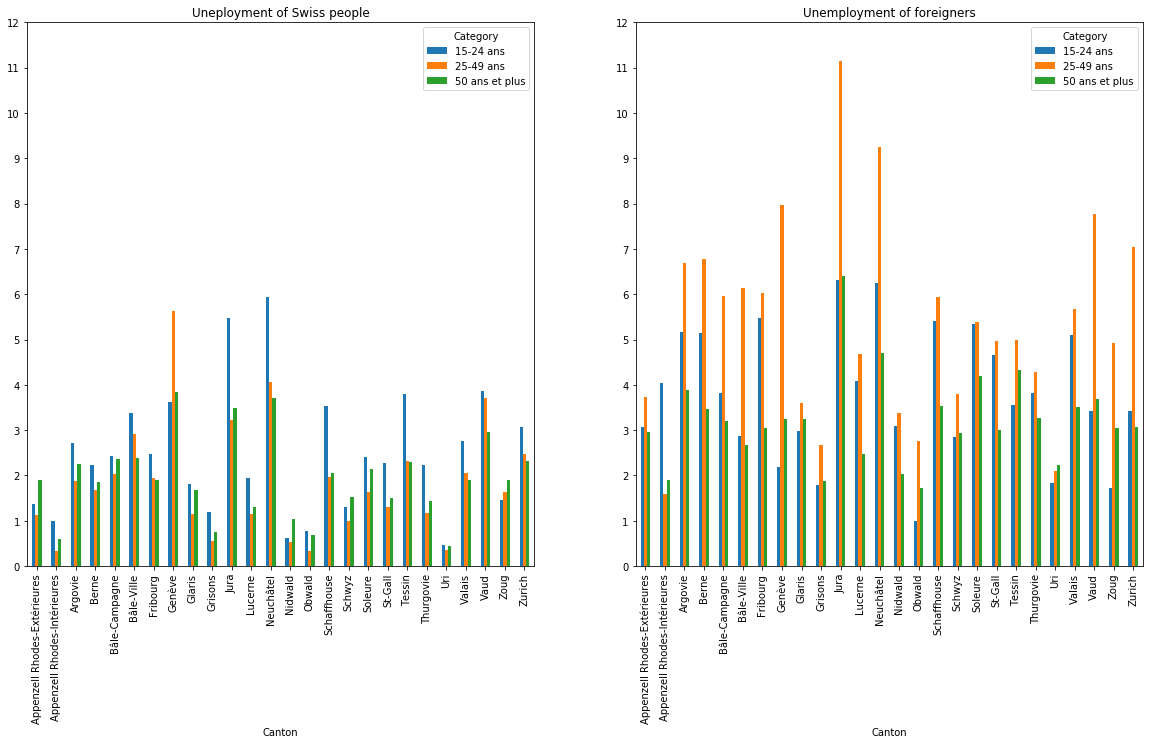

In [45]:
# cleanup dataframes, keeping only necessary information
# pour les suisses
suisses = unemp_count_nat_age[unemp_count_nat_age['Nationality'] == 'Suisses']
suisses = suisses[['Canton', 'Category', 'Rate']]
suisses = suisses.sort_values(by=['Canton', 'Category'])
# et les etrangers
foreign = unemp_count_nat_age[unemp_count_nat_age['Nationality'] == 'Etrangers']
foreign = foreign[['Canton', 'Category', 'Rate']]
foreign = foreign.sort_values(by=['Canton', 'Category'])

plt.figure()

#Pivot suisses dataframe
pivot_suisses = suisses.pivot_table(values='Rate', index="Canton", columns=["Category"])
pivot_suisses.reset_index(inplace=True)

#Pivot foreign dataframe
pivot_foreign = foreign.pivot_table(values='Rate', index="Canton", columns=["Category"])
pivot_foreign.reset_index(inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2)
pivot_suisses.plot(ax=axes[0], x=['Canton'], y=['15-24 ans', '25-49 ans', '50 ans et plus'], kind="bar",
                   figsize=(20, 10), title="Uneployment of Swiss people", yticks=range(13))
pivot_foreign.plot(ax=axes[1], x=['Canton'], y=['15-24 ans', '25-49 ans', '50 ans et plus'], kind="bar", 
                   figsize=(20, 10), title="Unemployment of foreigners", yticks=range(13))
plt.show()

#### Observations

After having added the age groups, we observe the same phenomenon as in the previous map plot.

That is that unemployment rates are higher in the foreign populations than in the Swiss populations, a fact that can be easily seen in the graphs above.

Surprisingly enough, the biggest difference between the Swiss and foreign unemployment rates can be spotted for the age group 25-49. It seems that foreigners of that age group have a harder time finding a job than the corresponding Swiss people.

## Question 4 [BONUS]

Using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

### Answer

We seperate cantons that belong to the French from those that belong to the German part of Switzerland. Some cantons are bilingual. Fribourg and Valais are assigned to the French part and Bern is assigned to the German part. The rest of the cantons belong to the other part of Switzerland, where Italian or Romansh is spoken.

In [46]:
french_part = ['Genève', 'Vaud', 'Neuchâtel', 'Jura', 'Fribourg', 'Valais/Wallis']
german_part = ['Zürich', 'Basel-Stadt', 'Basel-Landschaft', 'Aargau', 'Appenzell Innerrhoden', 'Appenzell Ausserrhoden',
               'Glarus', 'Luzern', 'Nidwalden', 'Obwalden', 'Schaffhausen', 'Schwyz', 'Solothurn',
               'St. Gallen', 'Thurgau', 'Uri', 'Bern/Berne']

We observe that in both scenarios of the exercise 2 cantons that belong to the french part have lower unemployment rates than the cantons of the german part. Of course this is just an observation.

In [47]:
def split_parts(canton, fr, de):
    if canton in fr:
        return 'fr'
    elif canton in de:
        return 'de'
    else:
        return 'other'

In [48]:
amstat_df1['Part'] = amstat_df1.apply(lambda row : split_parts(row['Canton'], french_part, german_part), axis=1)

In [49]:
amstat_df1.columns

Index(['Canton', 'Unemployed', 'Job_Seekers', 'Employed_Seekers',
       'Unemployed_Seekers', 'Unemployment_Rate', 'Job_Seekers_not_employed',
       'Unemployment_Rate2', 'Part'],
      dtype='object')

Based on the first part of the analysis of the second exercise.

In [50]:
unemployment_per_part = amstat_df1.groupby(by='Part')['Unemployment_Rate'].mean()
unemployment_per_part

Part
de       15.531613
fr       13.620753
other    14.406021
Name: Unemployment_Rate, dtype: float64

Based on the second part of the analysis of the second exercise.

In [51]:
unemployment_per_part2 = amstat_df1.groupby(by='Part')['Unemployment_Rate2'].mean()
unemployment_per_part2

Part
de       26.326587
fr       20.471759
other    25.997716
Name: Unemployment_Rate2, dtype: float64

**Observations**

As we already observed in both cases, when we sliced the dataframe into two parts (the German and the French)
and we obtained the mean from the two unemployment rates discussed in exercise 2, it turns out that German parts have higher unemployment rates than the French.